# Comparison of Propagation Modules (BP - CK)



Numerical simulations of the propagation of charged particles through magnetic fields, solving the equation of motion can be achieved in principle with many different algorithms. There are, however, an increasing number of studies that have found that there are two algorithms, which work in general best for propagating charged particles within a magnetic field [1,2,3]. These two algorithms are compared and evaluated.

Both the Boris push [4] and the Cash-Karp [3] algorithms solve the Lorentz equation and thus enable the propagation of charged particles through magnetic fields. For the simplest case of a homogeneous background field, the particle trajectory can be derived analytically. This enables comparison with numerical integrators and provides information on the errors of the algorithms for the corresponding parameters being used. The aim is to find a relationship between the error and the parameters applied. The pitch angle and the step length are suitable parameters to determine the influence. 

Consequently, we want to understand which algorithm is suitable for each simulation setup.

## Analytic Solution

The trajectory of a charged particle in a homogeneous background field can be solved analytically. We assume that the particle starts off with non-zero component of the momentum ($p_z > 0$) along the background magnetic field. The particle, then moves in a helix whose gyration radius is given by: $r_g = \frac{E}{B\cdot q \cdot c}$

The velocity component parallel to the background field remains constant. The analytical solution for the *direction = Vector3d(p_x, p_y, p_z)* with $p_x^2+p_y^2+p_z^2 = 1$ and the *position = Vector3d(0, 0, 0)* yields:

In [3]:
def analytical_solution(max_trajectory, p_z, r_g_0, number_steps):
    # calculate the time stamps similar to that used in the numerical simulation 
    t = np.linspace(0, max_trajectory/pc, int(number_steps+1))
    # shift the phase so that the analytical solution 
    # also starts at (0,0,0) with in the direction (p_x,p_y,p_z)
    d = t[1:]/r_g_0-3*math.pi/4.
    
    # for parallel motion corrected gyro radius
    r_g = r_g_0*(1-p_z**2)**0.5 

    # at these trajectory lengths, the numerical solutions are known
    x_ana = r_g*np.cos(d)
    y_ana = -r_g*np.sin(d)
    z_ana = p_z*t[1:]
    return x_ana, y_ana, z_ana

## Helper Functions

We define functions with which we can calculate the gyration radius and the circumference. In addition we only want to define how many steps we require per circumference and how many gyrations should be performed. The last helping function should then calculate the maximum trajectory length and the step size, so that our requirements are fulfilled.

In [4]:
import numpy as np
from crpropa import *
import math

# Gyro radius should be R_g = 10.810076 parsecs for p_z = 0 and B = 10nG and E = 100 TeV
def larmor_radius(c, field):
    p = c.current.getMomentum()
    try:
        B = field.getRegularField(c.current.getPosition())
    except:
        B = field.getField(c.current.getPosition())
        q = c.current.getCharge()
        p_perp = p.getPerpendicularTo(B)
    try:
        r =  abs(p_perp.getR() / (B.getR()*q))
    except ZeroDivisionError:
        r = 1000000
    return r

# Calculate gyro radius
def larmor_circumference(c, field):
    r_g_0 = larmor_radius(c, field)/pc # gyro radius for p_z = 0
    l_gyration = 2*math.pi*r_g_0*pc    # trajectory lenght of one gyration
    return r_g_0, l_gyration

# Trajectory length of particle in number of gyrations
def maximum_trajectory(steps_per_gyrations, number_of_gyrations, c, field, p_z):
    r_g_0, l_gyration = larmor_circumference(c, field)
    max_trajectory = l_gyration*number_of_gyrations
    steplength = l_gyration/np.array(steps_per_gyrations)
    return max_trajectory, steplength, r_g_0

## Run Simulation 

We can now compare the analytical solution with both particle integrators in CRPropa, namely the Boris push and the Cash-Karp.

First we have to add our propagation module with the above specialized background magnetic field to our module list. Afterwards we can specify that the particle information is collected at each step along the particle trajectory. With the output module, we can specify where these information will be saved. 

Now that we have our module list ready we can fire up our simulation with both propagation algorithms and hope that something visually interesting is going to happen. 

In [5]:
import time as Time

# We use only a Background magnetic field in the z-direction. 
# We could add more complex magentic fields to our MagneticFieldList.
B = 10*nG
direction_B = Vector3d(0, 0, 1)
  
const_mag_vec = direction_B * B
reg_field = UniformMagneticField(const_mag_vec)


### Running the simulation with either CK or BP
def run_simulation(module, steps_per_gyrations, number_of_gyrations, p_z):
    # Initial condition of candidate
    p_x = (1-p_z**2)**(1/2.)/2**0.5
    p_y = p_x
    E = 100 * TeV
    direction = Vector3d(p_x, p_y, p_z)
    position = Vector3d(0, 0, 0)
    
    c = Candidate(nucleusId(1, 1), E, position, direction)
    
    max_trajectory, steplength, r_g_0 = maximum_trajectory(steps_per_gyrations, number_of_gyrations, c, reg_field, p_z)
    
    sim = ModuleList()
    if module == 'CK':
        sim.add(PropagationCK(reg_field,1e-4,steplength, steplength))
        output = TextOutput('trajectory_CK.txt', Output.Trajectory3D)
    elif module == 'BP':
        sim.add(PropagationBP(reg_field, steplength))
        output = TextOutput('trajectory_BP.txt', Output.Trajectory3D)
    else:
        print('no module found. Use either BP or CK.')
        return
    
    # we only want to simulate a certain trajectory length
    sim.add(MaximumTrajectoryLength(max_trajectory))
    # the output information will be saved in pc instead of the default which is Mpc
    output.setLengthScale(pc)
    # each particle position will be saved in the above specified text field.
    sim.add(output)
    # compare the simulation time of both propagation methods
    t0 = Time.time()
    # run the simulation
    sim.run(c, True)
    t1 = Time.time()
    output.close()
    print('Simulation time with module '+ str(module)+' is '+str(t1-t0)+'s.')
    Time.sleep(0.5)
    return max_trajectory, p_z, r_g_0

## Load Simulation Data

There are several ways to load the simulation data. Pandas is helpful to load files. To illustrate this, we will load and process the data with pandas.

In [6]:
import pandas as pd

def load_data(text, r_g):
    data = pd.read_csv(text, 
                 names=['D','ID','E','X','Y','Z','Px','Py','Pz'], delimiter='\t', comment='#',
                 usecols=["D", "X", "Y", "Z","Px","Py","Pz"])

    ### distances are saved in units of pc
    ### transform so that the center of the gyromotion is at (0,0)
    data.X = data.X.values-r_g/2**0.5
    data.Y = data.Y.values+r_g/2**0.5
    ### convert disctance in kpc
    data.D = data.D.values/1000.
    
    ### calcualte gyro radius
    data['R'] = (data.X**2+data.Y**2)**0.5

    return data

## Compare the Propagation in the Perpendicular Plane

Here, we can compare the numerical results of both modules with the analytical solution of the particle trajectory. First, we want to show the trajectories in the $xy$-plane (left plot). The black squares present the positions of the analytical solution for the chosen step size. In the middle plot, we can display the relative error of the gyro radius as a function of time. Finally, we can compute the distance of the numerical solutions to the analytical solution in the $xy$-plane (right plot).

In [7]:
import matplotlib.pyplot as plt

steps_per_gyrations = 10
number_gyrations = 40000
number_of_steps = steps_per_gyrations * number_gyrations

def plot_subplots(ax1, ax2, ax3, data, x_ana, y_ana, r_g, module, color):
    # numerical calculated positions
    
    ax1.scatter(data.X,data.Y, s=1,color = color, label = module)
    
    # analytical solution shwon in black squares!
    if module == 'CK':
        ax1.scatter(x_ana, y_ana, color = 'k', marker = 's', s = 15)
        # for the legend
        ax1.scatter(x_ana, y_ana, color = 'k', marker = 's', s = 1, label = 'Analytical solution')
    
    ax1.legend(markerscale=5)
    
    # numerical solutions
    ax2.scatter(data.D,(data.R-r_g)/r_g*100., s=1,color = color, label= module)
    ax2.legend(markerscale=5)
    
    ax3.scatter(data.D,((x_ana-data.X)**2+(y_ana-data.Y)**2)**0.5, s=1,color = color, label=module)
    ax3.legend(markerscale=5)
   
 # We use this function to plot the whole figure for the particle motion in the xy-plane
def plot_figure_perp(max_trajectory, p_z, r_g_0, number_of_steps):
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3,figsize=(12,4))

    # for parallel motion corrected gyro radius
    r_g = r_g_0*(1-p_z**2)**0.5 
    
    # Initial condition of candidate
    p_x = (1-p_z**2)**(1/2.)/2**0.5
    p_y = p_x
    
    x_ana, y_ana, z_ana = analytical_solution(max_trajectory, p_z, r_g_0, number_of_steps)
    
    data = load_data('trajectory_BP.txt', r_g)
    plot_subplots(ax1, ax2, ax3, data, x_ana, y_ana, r_g, 'BP', 'brown')

    data = load_data('trajectory_CK.txt', r_g)
    plot_subplots(ax1, ax2, ax3, data, x_ana, y_ana, r_g, 'CK', 'dodgerblue')

    ax1.set_xlabel('$x$ [pc]')
    ax1.set_ylabel('$y$ [pc]')
    ax1.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    ax2.set_xlabel('distance [kpc]')
    ax2.set_ylabel('relative error in $r_\mathrm{g}$ [%]')
    ax2.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    ax3.set_xlabel('distance [kpc]')
    ax3.set_ylabel('$xy-$deviation from ana. solution [pc]')
    ax3.set_title('$p_z/p$ = '+str(p_z), fontsize=18)
    
    fig.tight_layout()
    plt.show()

We can study **different pitch angles** of the particle with respect to the background magnetic field and start with $p_z/p = 0.01$ which represents a strong perpendicular component:

Simulation time with module CK is 2.045074939727783s.
Simulation time with module BP is 1.3592238426208496s.


/home/lmerten/Software/matrix/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/lmerten/Software/matrix/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


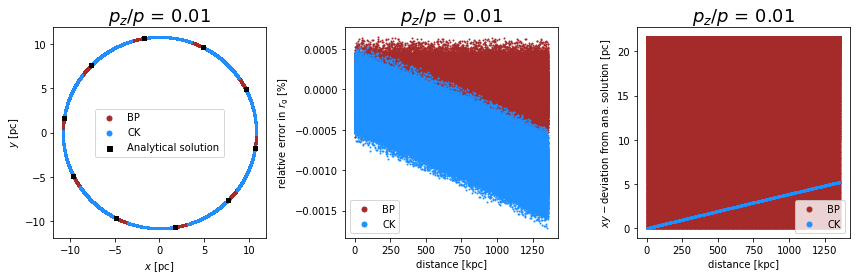

In [8]:
p_z = 0.01
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations, number_gyrations/2, p_z)
run_simulation('BP', steps_per_gyrations, number_gyrations/2, p_z)
plot_figure_perp(max_trajectory, p_z, r_g_0, number_of_steps/2)

We increase the component of the momentum along the parallel component:

Simulation time with module CK is 3.129796266555786s.
Simulation time with module BP is 3.1616051197052s.


/home/lmerten/Software/matrix/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


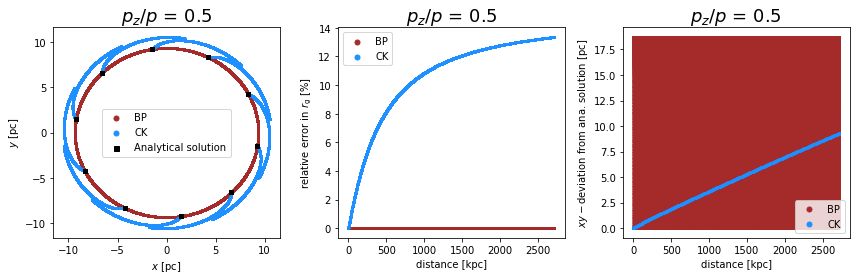

In [9]:
p_z = 0.5
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations, number_gyrations, p_z)
run_simulation('BP', steps_per_gyrations, number_gyrations, p_z)
plot_figure_perp(max_trajectory, p_z, r_g_0, number_of_steps)

Simulation time with module CK is 2.7734830379486084s.
Simulation time with module BP is 2.4479715824127197s.


/home/lmerten/Software/matrix/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


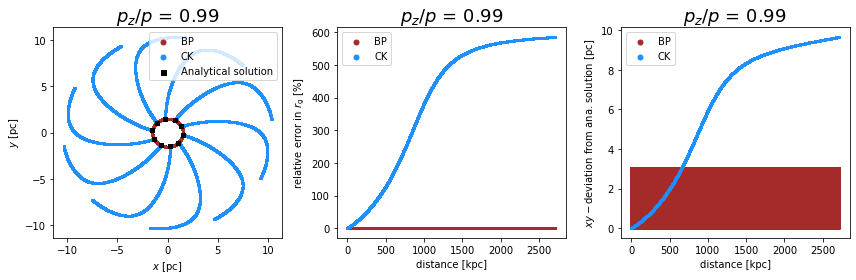

In [10]:
p_z = 0.99
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations, number_gyrations, p_z)
run_simulation('BP', steps_per_gyrations, number_gyrations, p_z)
plot_figure_perp(max_trajectory, p_z, r_g_0, number_of_steps)

Simulation time with module CK is 2.7557637691497803s.
Simulation time with module BP is 2.5037429332733154s.


/home/lmerten/Software/matrix/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


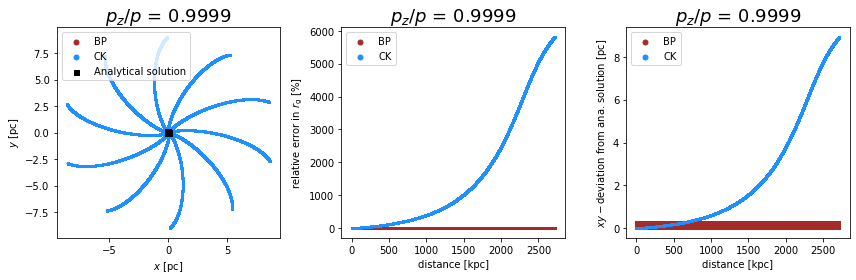

In [11]:
p_z = 0.9999
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations, number_gyrations, p_z)
run_simulation('BP', steps_per_gyrations, number_gyrations, p_z)
plot_figure_perp(max_trajectory, p_z, r_g_0, number_of_steps)

**Conclusions:** 
- the **Boris push** propagates the particle in the perpendicular plane, as expected, on a cirlce with a radius that is in great agreement with the gyro radius. The problem is that the frequency deviates from the analytical solution. Consequently, even though we can see an agreement between the numerical and analytical gyro radius, the deviation in the $xy$-plane is between 0 and $2r_g$. The **global error is constrained**.
- the **Cash-Karp** algorithm results in a relative **small local error** in the perpendicular plane for small components of the momentum along the parallel component of the magnetic field. The problem is that the small **local error accumulates to a large global error**. In addition, the **error depends on the pitch angle** (angle between particle direction and background magnetic field) of the particle and thus may artificially pollute the results if we use a background field in combination with an isotropic source of particles.

+ Note that other implementations of the CashKarp algorithm lead to different results, since CRPropa prevents the candidate from losing energy due to propagation alone. This is not true in general for other implementations. 

## Compare the Propagation in the Parallel Direction

We now turn to the parallel direction of the particle trajectory with respect to the background magnetic field. Along this direction a constant momentum is expected, resulting in a linear increase of the $z$-position. This time-behavior of the $z$-position is shown in the middle plots below. The left plot presents the movement in the $xz$-plane. An rectangle is expected (as it can be seen for the Boris push). In the right, the difference between the numerically calculated and theoretically expected time-behavior of the distance along the $z$-axis is plotted. Zero deviation in the right plot is preferable. While the Boris push has no deviation from the prediction, the Cash-Karp algorithm shows either a rapid increase in the $z$-direction or a decelerated movement which can result in a stagnation in the motion along the $z$-direction. The behavior depends on the ratio of $p_\mathrm{\parallel} / p$.

In [12]:
def plot_subplots_para(ax1, ax2, ax3, data, z_ana, module, color):
    ax1.plot(data.X,data.Z, markersize=0.01, marker='o',color = color, label=module)
    ax1.legend(markerscale=5)
    
    ax2.scatter(data.D,data.Z,s=1, color = color, label=module)
    ax2.legend(markerscale=5)
    
    # compare with analytical solution
    ax3.scatter(data.D, (data.D-z_ana),s=1, color = color, label=module)
    ax3.legend(markerscale=5)
    
def plot_figure_para(max_trajectory, p_z, r_g_0, number_of_steps):
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3,figsize=(12,4))
    
    # for parallel motion corrected gyro radius
    r_g = r_g_0*(1-p_z**2)**0.5 
    
    x_ana, y_ana, z_ana = analytical_solution(max_trajectory, p_z, r_g_0, number_of_steps)
    
    data = load_data('trajectory_BP.txt', r_g)
    plot_subplots_para(ax1, ax2, ax3, data, z_ana, 'BP', 'brown')

    data = load_data('trajectory_CK.txt', r_g)
    plot_subplots_para(ax1, ax2, ax3, data, z_ana, 'CK', 'dodgerblue')
    
    ax1.set_xlabel('$x$ [pc]')
    ax1.set_ylabel('$z$ [pc]')
    ax1.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    ax2.set_xlabel('distance [kpc]')
    ax2.set_ylabel('$z$ [pc]')
    ax2.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    ax3.set_xlabel('distance [kpc]')
    ax3.set_ylabel('difference in $z$ [pc]')
    ax3.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    fig.tight_layout()
    plt.show()

We can again study **different pitch angles** of the particle with respect to the background magnetic field and start with $p_z/p = 0.01$ which represents a strong perpendicular component:

Simulation time with module CK is 2.907780170440674s.
Simulation time with module BP is 2.5608789920806885s.


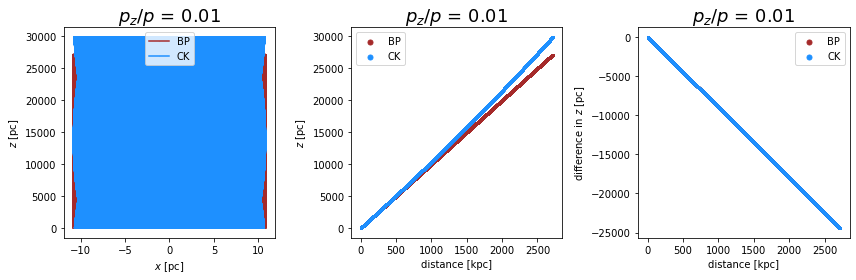

In [13]:
p_z = 0.01
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations, number_gyrations, p_z)
run_simulation('BP', steps_per_gyrations, number_gyrations, p_z)
plot_figure_para(max_trajectory, p_z, r_g_0, number_of_steps)

Simulation time with module CK is 2.9700050354003906s.
Simulation time with module BP is 2.6082756519317627s.


/home/lmerten/Software/matrix/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/lmerten/Software/matrix/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


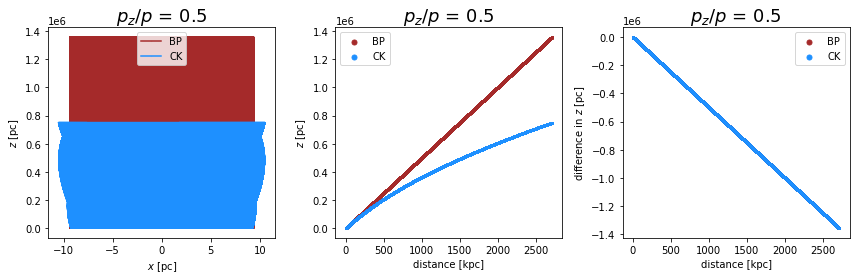

In [14]:
p_z = 0.5
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations, number_gyrations, p_z)
run_simulation('BP', steps_per_gyrations, number_gyrations, p_z)
plot_figure_para(max_trajectory, p_z, r_g_0, number_of_steps)

Simulation time with module CK is 2.992185592651367s.
Simulation time with module BP is 2.4518914222717285s.


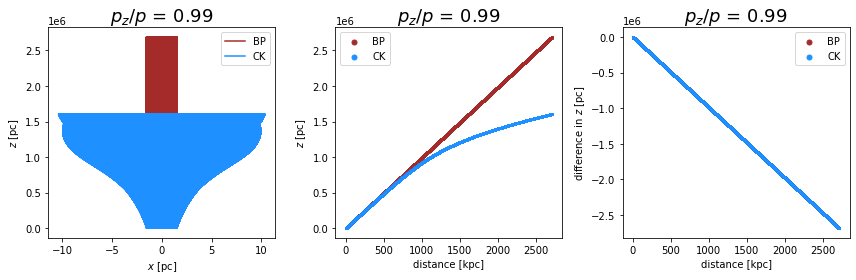

In [15]:
p_z = 0.99
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations, number_gyrations, p_z)
run_simulation('BP', steps_per_gyrations, number_gyrations, p_z)
plot_figure_para(max_trajectory, p_z, r_g_0, number_of_steps)

**Conclusions:**
- the **Boris push** propagates the particle along the parallel component **without any errors** and is in great agreement with the analytical solution.
- the behavior of the **Cash-Karp** on the other hand has again a **small local error that accumulates to a large global error**. Again, the **error depends on the pitch angle** of the particle and thus may artificially pollute the results if we use a background field in combination with a isotropic source (this source would emit particles with all possible pitch angles) of particles. 


If we are interested in the motion along the magnetic field lines, we should use the Boris push mehthod instead of the Cash-Karp method. 

## Conservation of Momentum 

CRPropa conserves the total energy and momentum of each particle during the propagation. However, only the Boris push conserves energy by construction. Urging the Cash-Karp algorithm to preserve energy and momentum leads to a shift of the energy from the perpendicular to the parallel component (or the other way round) as observed in this example of a pure background magnetic field. We have seen that the particle accelerates or slows down in the parallel direction.

We can study this effect also directly by plotting the components of the momentum as functions of the time (or distance which is equivilent for relativistic particles $v=c$).

We expect to have a constant momentum in both the parallel ($p_z/p$) and the perpendicular ($\sqrt{p_x^2+p_y^2}/p$) direction.

In [16]:
def plot_subplots_momentum(ax1, ax2, ax3, data, module, color):    
    ax1.scatter(data.D,((data.Px**2+data.Py**2)**0.5),s=1, color = color, label=module)
    ax1.legend(markerscale=5)
    
    ax2.scatter(data.D,data.Pz,s=1, color = color, label=module)
    ax2.legend(markerscale=5)
    
    ax3.scatter(data.D,(data.Pz-p_z)/p_z*100,s=1, color = color, label=module)
    ax3.legend(markerscale=5)
    
def plot_figure_momentum(max_trajectory, p_z, r_g_0, number_of_steps):
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3,figsize=(12,4))
    
    # for parallel motion corrected gyro radius
    r_g = r_g_0*(1-p_z**2)**0.5 
    
    x_ana, y_ana, z_ana = analytical_solution(max_trajectory, p_z, r_g_0, number_of_steps)
    
    # Initial condition of candidate
    p_x = (1-p_z**2)**(1/2.)/2**0.5
    p_y = p_x
    
    data = load_data('trajectory_BP.txt', r_g)
    plot_subplots_momentum(ax1, ax2, ax3, data, 'BP', 'brown')

    data = load_data('trajectory_CK.txt', r_g)
    plot_subplots_momentum(ax1, ax2, ax3, data, 'CK', 'dodgerblue')
    
    ax1.set_xlabel('distance [kpc]')
    ax1.set_ylabel('$\sqrt{p_x^2+p_y^2}/p$')
    ax1.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    ax2.set_xlabel('distance [kpc]')
    ax2.set_ylabel('$p_z/p$')
    ax2.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    ax3.set_xlabel('distance [kpc]')
    ax3.set_ylabel('relative error in $p_z$ [%]')
    ax3.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    fig.tight_layout()
    plt.show() 

We can start with small parallel component ($p_z$ = 0.01)...

Simulation time with module CK is 2.8336169719696045s.
Simulation time with module BP is 2.5191328525543213s.


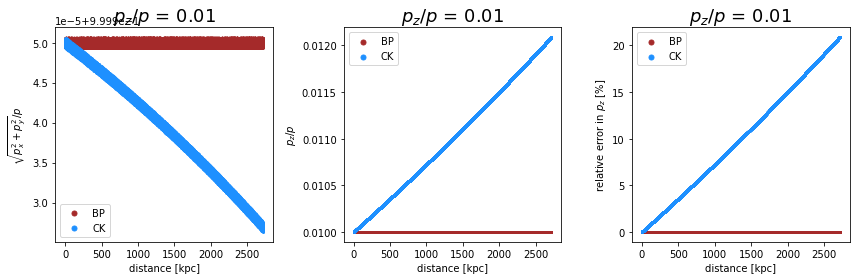

In [17]:
p_z = 0.01
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations, number_gyrations, p_z)
run_simulation('BP', steps_per_gyrations, number_gyrations, p_z)
plot_figure_momentum(max_trajectory, p_z, r_g_0, number_of_steps)

...and increase it so that is already dominating $p_z/p = 0.5 > p_x/p = p_y/p$...

Simulation time with module CK is 3.4364242553710938s.
Simulation time with module BP is 2.7046010494232178s.


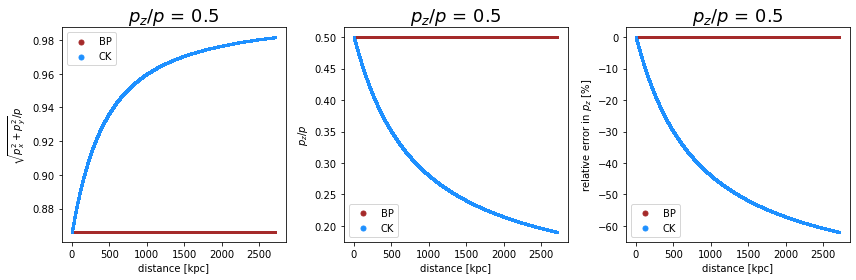

In [18]:
p_z = 0.5
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations, number_gyrations, p_z)
run_simulation('BP', steps_per_gyrations, number_gyrations, p_z)
plot_figure_momentum(max_trajectory, p_z, r_g_0, number_of_steps)

...and finally study two cases of really strong parallel motion ($p_z/p = 0.99$ and $p_z/p = 0.999)$):

Simulation time with module CK is 2.9141812324523926s.
Simulation time with module BP is 2.4687178134918213s.


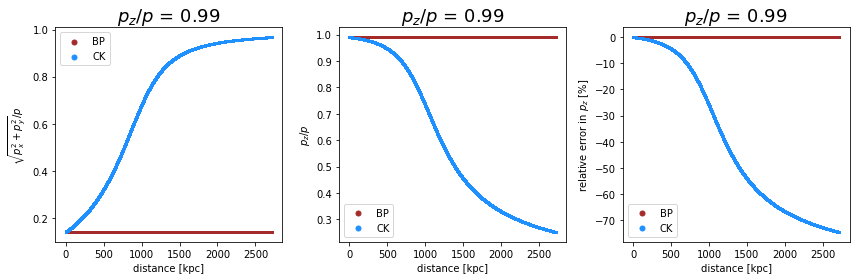

In [19]:
p_z = 0.99
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations, number_gyrations, p_z)
run_simulation('BP', steps_per_gyrations, number_gyrations, p_z)
plot_figure_momentum(max_trajectory, p_z, r_g_0, number_of_steps)

Simulation time with module CK is 3.6175737380981445s.
Simulation time with module BP is 2.5163893699645996s.


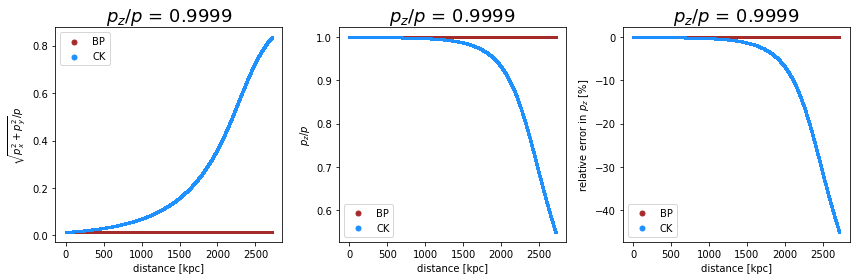

In [20]:
p_z = 0.9999
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations, number_gyrations, p_z)
run_simulation('BP', steps_per_gyrations, number_gyrations, p_z)
plot_figure_momentum(max_trajectory, p_z, r_g_0, number_of_steps)

**Conclusions:**
- The **Boris push** conserves the components of the momentum because the algorithm already conserves energy by construction.
- The **Cash-Karp** does not conserve energy by construction. CRPropa urges the propagation to conserve energy, resulting in a shift of the momentum between its components. This effect depends on the geometry of the magnetic field and the pitch angle (see above) of the particle as well as the step size (see below).

In the following two plots we can investigate the influence of the step size. We can consider for example 2 steps per gyration instead of 10 in the first figure and 50 steps per gyration in the second figure.

Simulation time with module CK is 1.010209321975708s.
Simulation time with module BP is 0.5810580253601074s.


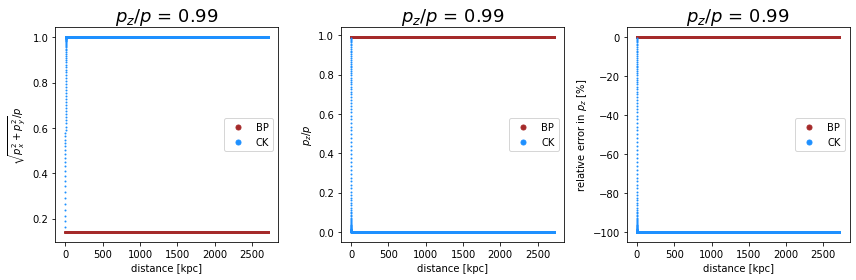

In [21]:
p_z = 0.99
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations/5, number_gyrations, p_z)
run_simulation('BP', steps_per_gyrations/5, number_gyrations, p_z)
plot_figure_momentum(max_trajectory, p_z, r_g_0, number_of_steps/5)

If we increase the number of steps per gyration, we expect to minimize the error of the Cash-Karp algorithm. 50 steps per gyration lead to:

Simulation time with module CK is 16.289583444595337s.
Simulation time with module BP is 12.5268075466156s.


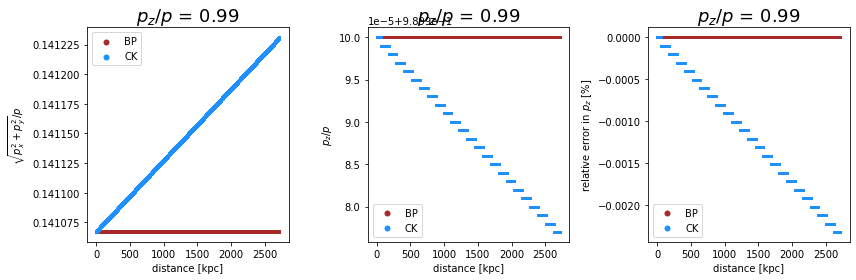

In [22]:
p_z = 0.99
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations*5, number_gyrations, p_z)
run_simulation('BP', steps_per_gyrations*5, number_gyrations, p_z)
plot_figure_momentum(max_trajectory, p_z, r_g_0, number_of_steps*5)

The conservation of the momentum with the Boris push is independet of the number of steps per gyration and works always, while it strongly depend on this number for the Cash-Karp algorithm. As expected, only the Boris push preserves the components of the momentum correctly. 2 steps per gyrations lead imediately to a complete change of the momentum components. Instead of a parallel motion as expected from the initial condition ($p_z/p$ = 0.99), the particle only moves in the perpendicular plane ($p_z/p$ = 0) after a short distance.
The behavior is much better for 50 steps per gyration (the simulation time is, however, high). The error is small at the investigated distances. Feel free to test different numbers of gyrations and different numbers of steps per gyration.

## Comparison with 3D Analytic Solution

We can study the complete deviation of the numerical trajectories from the analytical solution. The following code calculates the distance between the positions calculated with both algorithms and the analytical particle position. 

In [23]:
def plot_subplots_3d(ax, data, x_ana, y_ana, z_ana, module, color):   
    ax.scatter(data.D,((x_ana-data.X)**2+(y_ana-data.Y)**2+(z_ana-data.Z)**2)**0.5, s=1,color=color, label=module)
    ax.legend(markerscale=5)
    
def plot_figure_3d(max_trajectory, p_z, r_g_0, number_of_steps):
    fig, ax = plt.subplots(figsize=(12,5))
    
    # for parallel motion corrected gyro radius
    r_g = r_g_0*(1-p_z**2)**0.5 
    
    # Initial condition of candidate
    p_x = (1-p_z**2)**(1/2.)/2**0.5
    p_y = p_x
    
    x_ana, y_ana, z_ana = analytical_solution(max_trajectory, p_z, r_g_0, number_of_steps)
    
    data = load_data('trajectory_BP.txt', r_g)
    plot_subplots_3d(ax, data, x_ana, y_ana, z_ana, 'BP', 'brown')

    data = load_data('trajectory_CK.txt', r_g)
    plot_subplots_3d(ax, data, x_ana, y_ana, z_ana, 'CK', 'dodgerblue')
    
    ax.set_xlabel('distance [kpc]')
    ax.set_ylabel('$xyz-$deviation from analytical solution [pc]')
    ax.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    fig.tight_layout()
    plt.show() 

Simulation time with module CK is 3.250000476837158s.
Simulation time with module BP is 2.8336546421051025s.


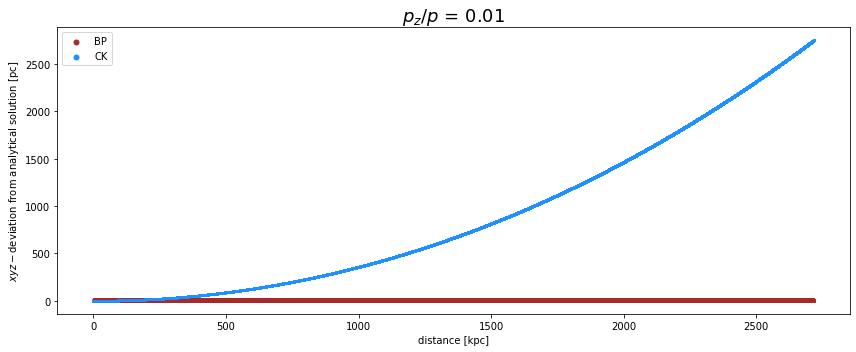

In [24]:
p_z = 0.01
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations, number_gyrations, p_z)
run_simulation('BP', steps_per_gyrations, number_gyrations, p_z)
plot_figure_3d(max_trajectory, p_z, r_g_0, number_of_steps)

Simulation time with module CK is 3.026798725128174s.
Simulation time with module BP is 2.7702648639678955s.


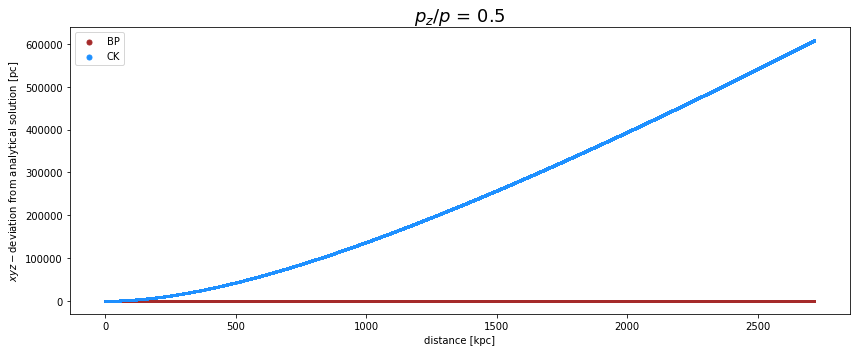

In [25]:
p_z = 0.5
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations, number_gyrations, p_z)
run_simulation('BP', steps_per_gyrations, number_gyrations, p_z)
plot_figure_3d(max_trajectory, p_z, r_g_0, number_of_steps)

Simulation time with module CK is 2.8276591300964355s.
Simulation time with module BP is 2.6629881858825684s.


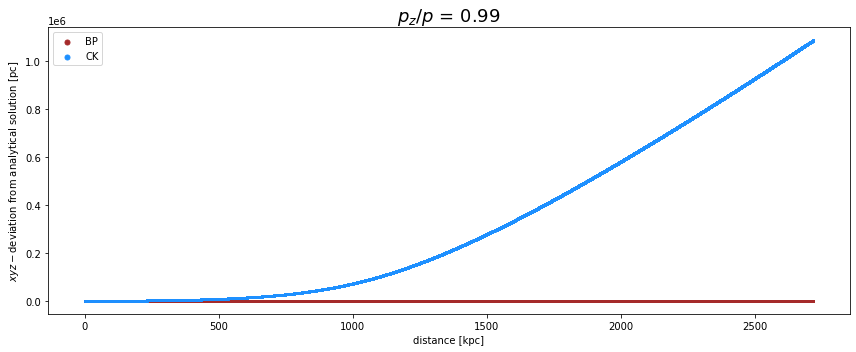

In [26]:
p_z = 0.99
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations, number_gyrations, p_z)
run_simulation('BP', steps_per_gyrations, number_gyrations, p_z)
plot_figure_3d(max_trajectory, p_z, r_g_0, number_of_steps)

Simulation time with module CK is 2.818937301635742s.
Simulation time with module BP is 2.5782644748687744s.


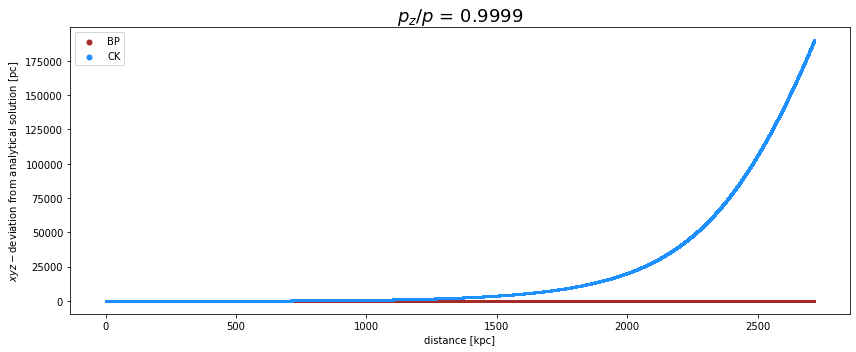

In [27]:
p_z = 0.9999
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations, number_gyrations, p_z)
run_simulation('BP', steps_per_gyrations, number_gyrations, p_z)
plot_figure_3d(max_trajectory, p_z, r_g_0, number_of_steps)

The Boris push is for long simulations for all presented cases better and faster than the Cash-Karp algorithm. If we are only interested in small distances and we don't care about long simulation times, the Cash-Karp algorithm outperforms the Boris push as presented below (40 steps per gyration and $p_z/p = 0.01$):

Simulation time with module CK is 2.885383367538452s.
Simulation time with module BP is 2.626239061355591s.


/home/lmerten/Software/matrix/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/lmerten/Software/matrix/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


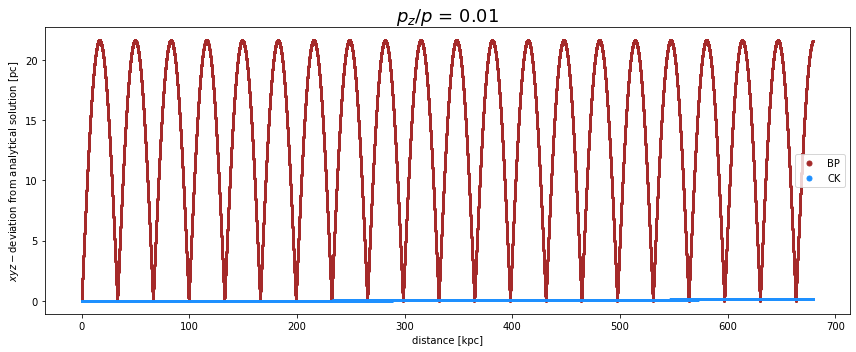

In [28]:
p_z = 0.01
max_trajectory, p_z, r_g_0 = run_simulation('CK', steps_per_gyrations*4, number_gyrations/4, p_z)
run_simulation('BP', steps_per_gyrations*4, number_gyrations/4, p_z)
plot_figure_3d(max_trajectory, p_z, r_g_0, number_of_steps)

**The main findings of this tutorial are highlighted:**
- The Cash-Karp algorithm has a small local error, which accumulates over time to a large global error. The components of the momentum are not conserved. Due to the small local error (for small step sizes), the module PropagationCK is, however, useful for short simulations, where the exact position is crucial. 
- The Boris push has a compareable large local error, which does not accumulate over time, resulting in a small global error. The accuracy doesn't depend too much on the step size, especially not in the direction where the magnetic field should have no influence based on alaytical arguments ($z$-axis in this example). 

Therefore, for almost all simulation scenarios, **the PropagationBP module outperforms the PropagationCK module in both simulation time and accuracy**.

## Comparison of Simulation Time 

We have already compared the simulation times for a background magnetic field. Now we can compare the simulation time of both modules for a different magnetic field, namely the turbulent magnetic field. The Boris push calls the magnetic field only once per step, whereas the Cash-Karp algorithm needs the field at the current position six times per step. For analytical fields where the field is known at every location (for example the background magnetic field), the time difference is much smaller than for magnetic fields where the current magnetic field vector has to be interpolated first. The latter is especially relevant for the turbulent magnetic fields initialized on grids.

### Turbulent Magnetic Field

The inialisation of the turbulent magnetic field vectors on the grid points takes some time:

In [33]:
### Setup turbulent magnetic field
randomSeed = 42
lMin = 0.1*pc
lMax = 5.*pc
N_grid = 256
b = 100*nG
spacing = lMin/2.
#spacing = R / 2 *pc  # lMin > 2 * spacing
#vgrid = Grid3f(Vector3d(0), N_grid, spacing)
#initTurbulence(vgrid, b, lMin, lMax, -11./3., randomSeed)
#turb_field = MagneticFieldGrid(vgrid)

turbSpectrum = SimpleTurbulenceSpectrum(Brms=b, lMin=lMin, lMax=lMax, sIndex=5./3.)
gridprops = GridProperties(Vector3d(0), N_grid, spacing)
turb_field = SimpleGridTurbulence(turbSpectrum, gridprops, randomSeed)

Finally, we can run both propagation modules and compare their simulation times:

In [39]:
# ### Running the simulation with either CK or BP
def runSimulation(module):
    sim = ModuleList()
    steplength = 1.*pc
    if module == 'CK':
        sim.add(PropagationCK(turb_field,1e-4,steplength, steplength))
    elif module == 'BP':
        sim.add(PropagationBP(turb_field, steplength))
    else:
        print('no module found. Use either BP or CK.')
        return
    
    sim.add(MaximumTrajectoryLength(10*Mpc))
    # Proton
    c = Candidate(nucleusId(1, 1), 100*TeV, Vector3d(0,0,0), Vector3d(1,0,0))

    # compare the simulation time of both propagation methods
    t0 = Time.time()
    sim.run(c, True)
    t1 = Time.time()
    print('Simulation time with module {} is {:4.4} s.'.format(module, t1-t0))
    Time.sleep(4)

In [40]:
runSimulation('BP')
runSimulation('CK')

Simulation time with module BP is 5.822 s.
Simulation time with module CK is 27.11 s.


The simulation time difference is really high! **PropagationBP is much faster than PropagationCK for the turbulent magnetic field**.

## Time Comparison for Galactic Trajectories

#### For fixed step sizes

Here, we test the time difference for the example of galactic trajectories presented in: 

https://github.com/CRPropa/CRPropa3-notebooks/blob/master/galactic_trajectories/galactic_trajectories.v4.ipynb.

First, we want to compare both modules with a fixed step size:

In [41]:
from crpropa import *
import time as Time

# magnetic field setup
B = JF12Field()
randomSeed = 691342
B.randomStriated(randomSeed)
B.randomTurbulent(randomSeed)

# simulation setup for fixed step size
sim_CK = ModuleList()
sim_CK.add(PropagationCK(B, 1e-4, 0.1 * parsec, 0.1 * parsec))
sim_CK.add(SphericalBoundary(Vector3d(0), 20 * kpc))

sim_BP = ModuleList()
sim_BP.add(PropagationBP(B, 0.1 * parsec))
sim_BP.add(SphericalBoundary(Vector3d(0), 20 * kpc))

class MyTrajectoryOutput(Module):
    """
    Custom trajectory output: i, x, y, z
    where i is a running cosmic ray number
    and x,y,z are the galactocentric coordinates in [kpc].
    """
    def __init__(self, fname):
        Module.__init__(self)
        self.fout = open(fname, 'w')
        self.fout.write('#i\tX\tY\tZ\n')
        self.i = 0
    def process(self, c):
        v = c.current.getPosition()
        x = v.x / kpc
        y = v.y / kpc
        z = v.z / kpc
        self.fout.write('%i\t%.3f\t%.3f\t%.3f\n'%(self.i, x, y, z))
        if not(c.isActive()):
            self.i += 1       
    def close(self):
        self.fout.close()
    

output_CK = MyTrajectoryOutput('galactic_trajectories_CK.txt')
output_BP = MyTrajectoryOutput('galactic_trajectories_BP.txt')

sim_CK.add(output_CK)
sim_BP.add(output_BP)

# source setup
source = Source()
source.add(SourcePosition(Vector3d(-8.5, 0, 0) * kpc))
source.add(SourceIsotropicEmission())
source.add(SourceParticleType(-nucleusId(1,1)))
source.add(SourceEnergy(1 * EeV))

t0 = Time.time()
sim_CK.run(source, 10)  # backtrack 10 random cosmic rays
t1 = Time.time()
print('Simulation time with module CK is {:4.4} s.'.format(t1-t0))
output_CK.close() # flush particles to ouput file

t2 = Time.time()
sim_BP.run(source, 10)  # backtrack 10 random cosmic rays
t3 = Time.time()
print('Simulation time with module BP is {:4.4} s.'.format(t3-t2))
output_BP.close() # flush particles to ouput file

Simulation time with module CK is 86.28928446769714s.
Simulation time with module BP is 44.579694986343384s.


PropagationBP is faster than PropagationCK for the same step sizes.

#### Adaptive step sizes

Finally we can test exactly the example presented in:
https://github.com/CRPropa/CRPropa3-notebooks/blob/master/galactic_trajectories/galactic_trajectories.v4.ipynb.


In [45]:
# magnetic field setup
B = JF12Field()
randomSeed = 691342
B.randomStriated(randomSeed)
B.randomTurbulent(randomSeed)

# simulation setup for adaptive step size for the Cash-Karp algorithm
sim_CK = ModuleList()
sim_CK.add(PropagationCK(B, 1e-4, 0.1 * parsec, 100 * parsec))
sim_CK.add(SphericalBoundary(Vector3d(0), 20 * kpc))

# simulation setup for adaptive step size for the Boris push algorithm with a higher tolerance 
# so that it is as fast as the Cash-Karp algorithm.
sim_BP = ModuleList()
sim_BP.add(PropagationBP(B, 2e-3, 0.1 * parsec, 100 * parsec))
sim_BP.add(SphericalBoundary(Vector3d(0), 20 * kpc))

class MyTrajectoryOutput(Module):
    """
    Custom trajectory output: i, x, y, z
    where i is a running cosmic ray number
    and x,y,z are the galactocentric coordinates in [kpc].
    """
    def __init__(self, fname):
        Module.__init__(self)
        self.fout = open(fname, 'w')
        self.fout.write('#i\tX\tY\tZ\n')
        self.i = 0
    def process(self, c):
        v = c.current.getPosition()
        x = v.x / kpc
        y = v.y / kpc
        z = v.z / kpc
        self.fout.write('%i\t%.3f\t%.3f\t%.3f\n'%(self.i, x, y, z))
        if not(c.isActive()):
            self.i += 1       
    def close(self):
        self.fout.close()
    

output_CK = MyTrajectoryOutput('galactic_trajectories_CK.txt')
output_BP = MyTrajectoryOutput('galactic_trajectories_BP.txt')

sim_CK.add(output_CK)
sim_BP.add(output_BP)

# source setup
source = Source()
source.add(SourcePosition(Vector3d(-8.5, 0, 0) * kpc))
source.add(SourceIsotropicEmission())
source.add(SourceParticleType(-nucleusId(1,1)))
source.add(SourceEnergy(1 * EeV))

t0 = Time.time()
sim_CK.run(source, 10)  # backtrack 10 random cosmic rays
t1 = Time.time()
print('Simulation time with module CK is {:4.4} s.'.format(t1-t0))
output_CK.close() # flush particles to ouput file

t2 = Time.time()
sim_BP.run(source, 10)  # backtrack 10 random cosmic rays
t3 = Time.time()
print('Simulation time with module BP is {:4.4} s.'.format(t3-t2))
output_BP.close() # flush particles to ouput file

Simulation time with module CK is 0.4632 s.
Simulation time with module BP is  0.6 s.


The simulation time depends on the tolerance. For the same tolerance, the PropagationCK is much faster than PropagationBP. 

If the tolerance of the PropagationBP module is adjusted to 2e-3 (instead of 1e-4), both simulation times are the same. The big differences can be explained by the different orders of the algorithms. Whereas the Cash-Karp is a higher order algorithm, the Boris push is only of order 2.

#### Literature

[1] Hong Qin et al. “Why is Boris algorithm so good?” In: Physics of Plasmas 20.8 (2013),
p. 084503. doi: 10.1063/1.4818428. url: https://doi.org/10.1063/1.4818428.

[2] Mathias Winkel, Robert Speck, and Daniel Ruprecht. “Does Boris-SDC conserve phase space
volume?” In: PAMM 15.1 (2015), pp. 687–688. doi: 10.1002/pamm.201510333. url: https:
//onlinelibrary.wiley.com/doi/abs/10.1002/pamm.201510333.

[3] J. R. Cash and Alan H. Karp. “A Variable Order Runge-Kutta Method for Initial Value Problems
with Rapidly Varying Right-hand Sides”. In: ACM Trans. Math. Softw. 16.3 (Sept. 1990),
pp. 201–222. issn: 0098-3500. doi: 10.1145/79505.79507. url: http://doi.acm.org/10.
1145/79505.79507.

[4] J. Boris, in Proc. of the 4th Conf. on Numerical Simulation of Plasmas (NRL, 1970), pp. 3-67.